## Setup

In [1]:
import os.path as osp
from collections import defaultdict

import networkx as nx
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:

# If on colab

from google.colab import drive

drive.mount("/content/drive")

BASE_DIR = "/content/drive/MyDrive/Network ML/Project"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# If local
BASE_DIR = "../data/"

In [3]:
FIGURES_DIR = "../media/"

In [138]:
plt.rcParams.update({"font.size": 12})

## Graph

We work in this project with Twitter's retweet graph. The graph is directed and unweighted. The nodes are Twitter users and the edges are retweets, with an edge from user A to user B if A retweeted B.

In [218]:
G = nx.read_graphml(osp.join(BASE_DIR, "users_clean.graphml"))

In [5]:
# Print descriptive statistics such as number of nodes, edges, etc.
print(
    f"The graph contains {G.number_of_nodes()} nodes and {G.number_of_edges()} edges."
)

The graph contains 100386 nodes and 2286592 edges.


## Node attributes

In [96]:
df = pd.read_csv(osp.join(BASE_DIR, "users_neighborhood_anon.csv"), index_col=0)

In [97]:
# remove user_id from index and add it as a column
df.reset_index(inplace=True)

For a description of features see https://www.kaggle.com/datasets/manoelribeiro/hateful-users-on-twitter

We only keep the features that represent attributes from the Twitter profile and from the text of the tweets, i.e. we remove the features that can be computed from the graph. Specifically, we do not consired the features aggregated from neighbors, since we will use Graph Machine Learning methods that, hopefully, extract the same kind of information in better ways. We also do not consider the features that are computed from the graph structure, such as centrality measures, since we will extract them ourselves later.

In [103]:
columns = list(df.columns)

features = [
    # "user_id",
    "hate",
    # "hate_neigh",
    # "normal_neigh",
    "statuses_count",
    "followers_count",
    "followees_count",
    "favorites_count",
    "listed_count",
    "betweenness",
    "eigenvector",
    # "in_degree",
    # "out_degree",
    "sentiment",
    "subjectivity",
    "number hashtags",
    # "hashtags",
    "tweet number",
    "retweet number",
    "quote number",
    "status length",
    "number urls",
    "baddies",
    "mentions",
    # "is_50",
    # "is_63",
    # "is_50_2",
    # "is_63_2",
    "time_diff",
    "time_diff_median",
    "created_at",
]

features += list(
    filter(lambda x: x.endswith("_empath") and not x.startswith("c_"), columns)
)
features += list(
    filter(lambda x: x.endswith("_glove") and not x.startswith("c_"), columns)
)

In [104]:
df = df[features]
df

,hate,statuses_count,followers_count,followees_count,favorites_count,listed_count,betweenness,eigenvector,sentiment,subjectivity,...,290_glove,291_glove,292_glove,293_glove,294_glove,295_glove,296_glove,297_glove,298_glove,299_glove
0,normal,101767,3504,3673,81635,53,100467.895084,7.413433e-09,0.035132,0.431656,...,-0.162803,0.022277,-0.061740,-0.108736,0.095297,0.014048,-0.079171,-0.064034,0.039573,0.121562
1,other,2352,19609,309,61,197,0.000000,4.929853e-32,0.088142,0.418649,...,-0.220041,0.061212,0.045925,-0.090857,0.033579,-0.038353,-0.068932,-0.076778,0.016700,0.081580
2,other,1044,2371,2246,561,16,4897.117853,6.876258e-12,0.117861,0.455828,...,-0.071102,0.044288,0.044124,-0.058129,-0.026722,-0.034385,-0.015848,-0.033579,-0.015725,0.110611
3,other,167172,3004,298,3242,53,9.864754,1.380359e-30,0.261688,0.558544,...,-0.085447,0.039014,0.014094,-0.090334,0.155788,-0.006964,-0.071013,-0.043521,0.023655,0.126403
4,other,1998,17643,19355,485,239,0.000000,4.929853e-32,0.121533,0.435334,...,-0.162940,0.112401,-0.109144,-0.143494,-0.015770,0.184437,0.015669,0.074143,-0.107558,-0.102976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100381,other,6425,70081,551,1770,223,91339.873881,3.597781e-09,0.174331,0.511019,...,-0.101585,0.056177,-0.011879,-0.079700,0.057477,-0.037915,-0.044164,-0.029799,-0.056733,0.108609
100382,other,16928,62727,463,52132,100,68208.504656,2.035614e-08,0.227946,0.571372,...,-0.048893,-0.034731,-0.102936,-0.107279,0.135280,-0.022714,-0.062393,-0.037941,-0.016274,0.070525
100383,other,1118,12885,29,0,598,80904.560366,8.692683e-10,0.182165,0.446904,...,-0.139124,0.025163,0.048279,-0.062656,0.027198,-0.054500,-0.013992,-0.046172,-0.037651,0.112789
100384,other,3359,517,137,595,17,37072.184175,5.349281e-10,0.116135,0.541092,...,-0.140663,0.020672,-0.031872,-0.104729,0.103883,-0.035841,-0.071515,-0.048701,0.055673,0.084698


## 1. Preliminary exploration
In this section, we carry out some exploratory analysis of the dataset. 
We will have a look at: 
1. The degree distribution of the graph
2. Connectivity of the graph
3. The distribution of the features
4. The correlation between features and labels

### 1.1 Degree distribution

In [107]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]

df["in_degree"] = in_degrees
df["out_degree"] = out_degrees

/tmp/ipykernel_27369/1203834831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["in_degree"] = in_degrees


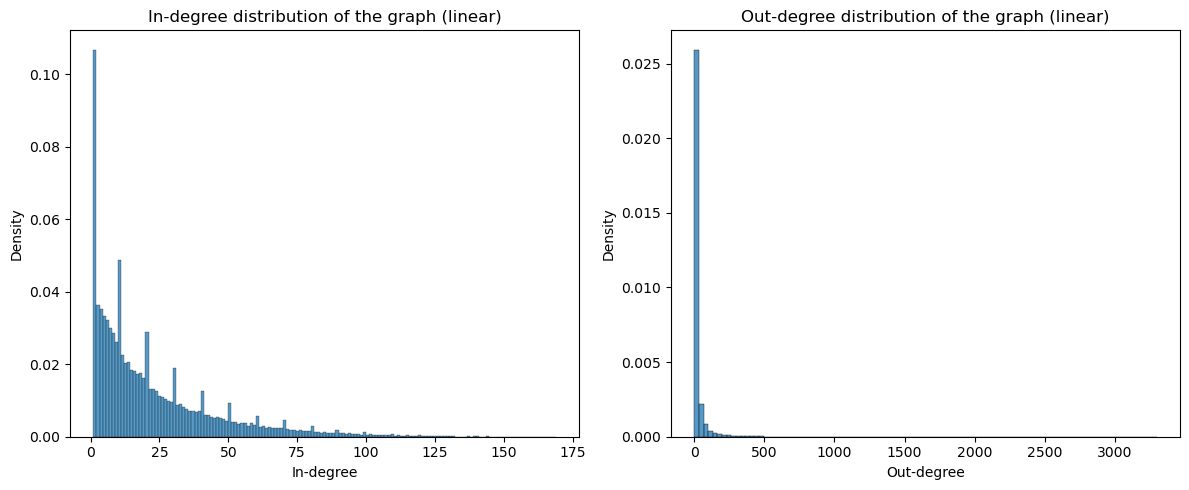

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df, x="in_degree", ax=ax[0], stat="density")
sns.histplot(df, x="out_degree", bins=100, ax=ax[1], stat="density")
ax[0].set_xlabel("In-degree")
ax[1].set_xlabel("Out-degree")
ax[0].set_ylabel("Density")
ax[1].set_ylabel("Density")
ax[0].set_title("In-degree distribution of the graph (linear)")
ax[1].set_title("Out-degree distribution of the graph (linear)")
plt.tight_layout()
plt.savefig(FIGURES_DIR + "degree-linear.pdf")

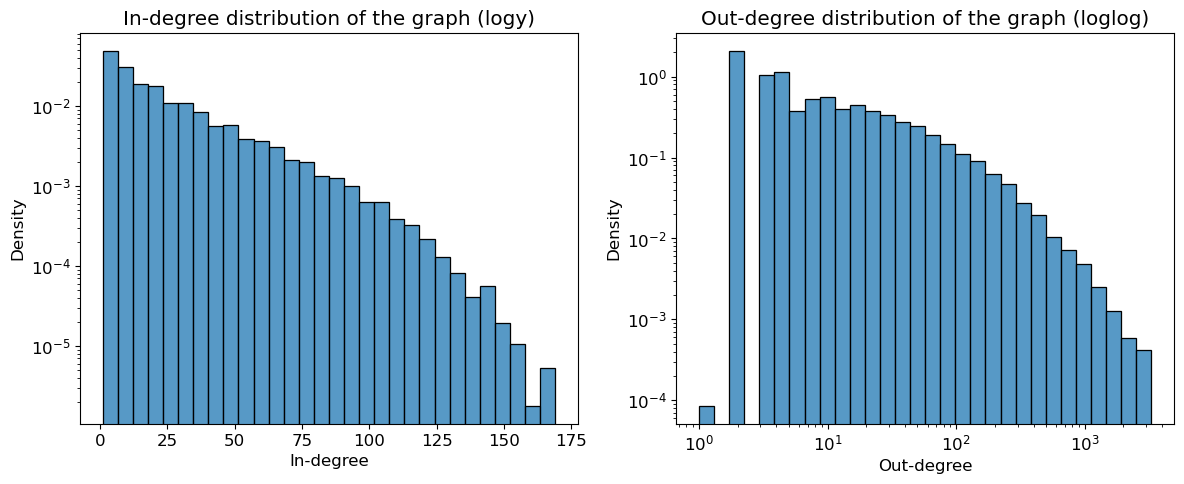

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df, x="in_degree", bins=30, ax=ax[0], log_scale=[False, True], stat="density")
sns.histplot(df, x="out_degree", bins=30, ax=ax[1], log_scale=[True, True], stat="density")
ax[0].set_xlabel("In-degree")
ax[1].set_xlabel("Out-degree")
ax[0].set_ylabel("Density")
ax[1].set_ylabel("Density")
ax[0].set_title("In-degree distribution of the graph (logy)")
ax[1].set_title("Out-degree distribution of the graph (loglog)")
plt.tight_layout()
plt.savefig(FIGURES_DIR + "degree-log.pdf")

We observe that the in-degree distribution decreases with a trend close to exponential, while the out-degree distribution approximately follows a power law. This follows a similar pattern to what we normally find in social media, considering that we are dealing with a retweet graph and not with a follow graph: in-degree represents the number of retweets by an user, while out-degree represents the number of times a user has been retweeted. Therefore, it is reasonable that the latter has a much heavier tail, since there are celebrities that are retweeted by a very large number of users. On the other side, the number of retweets done by an user only grows to a certain extent, and has a smaller variance.

Interestingly, we also observe that the number of retweets per user has spikes corresponding to multiples of 10. This is a suspicious behavior, and we will investigate it further in the following.

We can consider the graph as undirected and check its degree distribution, combining both in and out degrees.

In [20]:
G_undirected = G.to_undirected()
degrees = [G_undirected.degree(n) for n in G_undirected.nodes()]

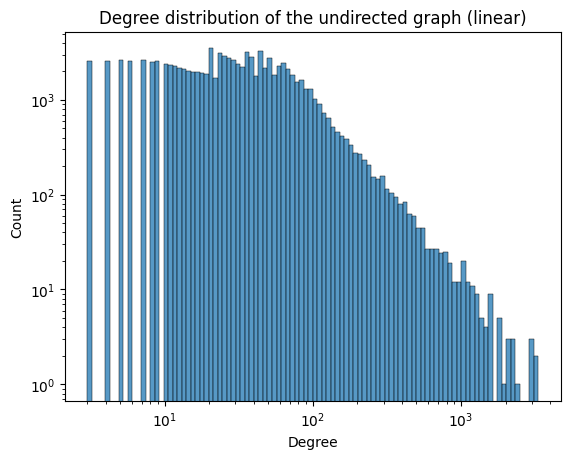

In [21]:
sns.histplot(degrees, bins=100, log_scale=[True, True])
plt.xlabel("Degree")
plt.ylabel("Count")
plt.title("Degree distribution of the undirected graph (linear)")
plt.show()

### 1.2 Connectivity

Considering the graph as undirected also allows us to check the connected components

In [ ]:
# connected components
cc = list(nx.connected_components(G_undirected))
cc = sorted(cc, key=len, reverse=True)
print(f"The graph has {len(cc)} connected components.")

The graph has 1 connected components.


### 1.3 Feature distribution

In [13]:
features_analyzed = [
    "hate",
    "betweenness",
    "eigenvector",
    "statuses_count",
    "followers_count",
    "followees_count",
    "favorites_count",
    "listed_count",
    "sentiment",
    "subjectivity",
    "tweet number",
    "retweet number",
    "quote number",
    "status length",
    "baddies",
    "mentions",
]

In [14]:
df[features_analyzed].describe()

,betweenness,eigenvector,statuses_count,followers_count,followees_count,favorites_count,listed_count,sentiment,subjectivity,tweet number,retweet number,quote number,status length,baddies,mentions
count,1.003860e+05,1.003860e+05,1.003860e+05,1.003860e+05,1.003860e+05,1.003860e+05,100386.000000,100009.000000,100009.000000,100009.000000,100009.00000,100009.000000,100009.000000,100009.000000,100009.000000
mean,7.160818e+04,1.936468e-04,2.788436e+04,1.131832e+05,2.891717e+03,1.279354e+04,534.857789,0.133680,0.502814,122.751612,72.11093,16.060975,108.729326,21.629353,150.361048
std,2.304413e+05,3.150262e-03,6.325047e+04,1.300094e+06,2.097654e+04,3.255763e+04,3742.277767,0.086279,0.066993,52.832745,51.51704,18.919533,30.925540,18.214057,182.703546
min,0.000000e+00,4.929853e-32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.000000,0.000000,0.000000,0.00000,0.000000,3.000000,0.000000,0.000000
25%,1.776317e+03,2.065465e-10,2.436000e+03,7.820000e+02,3.000000e+02,5.660000e+02,10.000000,0.073995,0.466946,84.000000,29.00000,2.000000,85.120000,10.000000,65.000000
50%,1.381725e+04,3.107299e-09,9.102000e+03,2.947000e+03,7.070000e+02,2.736500e+03,56.000000,0.121134,0.507132,130.000000,65.00000,10.000000,111.320000,17.000000,125.000000
75%,6.545606e+04,2.411091e-08,2.885200e+04,1.437475e+04,1.581000e+03,1.087200e+04,245.000000,0.183746,0.543520,167.000000,109.00000,23.000000,130.705000,28.000000,199.000000
max,1.310454e+07,8.658241e-02,7.756870e+06,1.055672e+08,3.078587e+06,1.030071e+06,615331.000000,1.000000,1.000000,200.000000,200.00000,199.000000,912.330000,568.000000,11657.000000


In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i, feature in enumerate(features_analyzed[1:]):
    sns.histplot(df[feature], ax=ax[i // 4, i % 4])
    ax[i // 4, i % 4].set_xlabel(feature)
    ax[i // 4, i % 4].set_ylabel("Count")
    ax[i // 4, i % 4].set_title(f"{feature} distribution")
for i in range(3, 4):
    ax[3, i].set_axis_off()

plt.tight_layout()
plt.savefig(FIGURES_DIR + "features-linear.pdf")

We repeat the same plots with appropriate logscales, where needed.

In [62]:
df_logscale = df.copy()
df_logscale.mentions = df_logscale.mentions.fillna(0).astype(int)


for column in features_analyzed[1:]:
    if column in ["eigenvector", "sentiment", "subjectivity"]:
        df_logscale[column] = df_logscale[column] + 1e-33
    else:
        df_logscale[column] = df_logscale[column].apply(lambda x: max(1, x))

In [77]:
logscale = [[True, False],
            [True, False],
            [True, False],
            [True, False],
            [True, False],
            [True, False],
            [True, False],
            [False, False],
            [False, False],
            [False, False],
            [False, False],
            [False, True],
            [False, True],
            [False, True],
            [True, False],
            ]

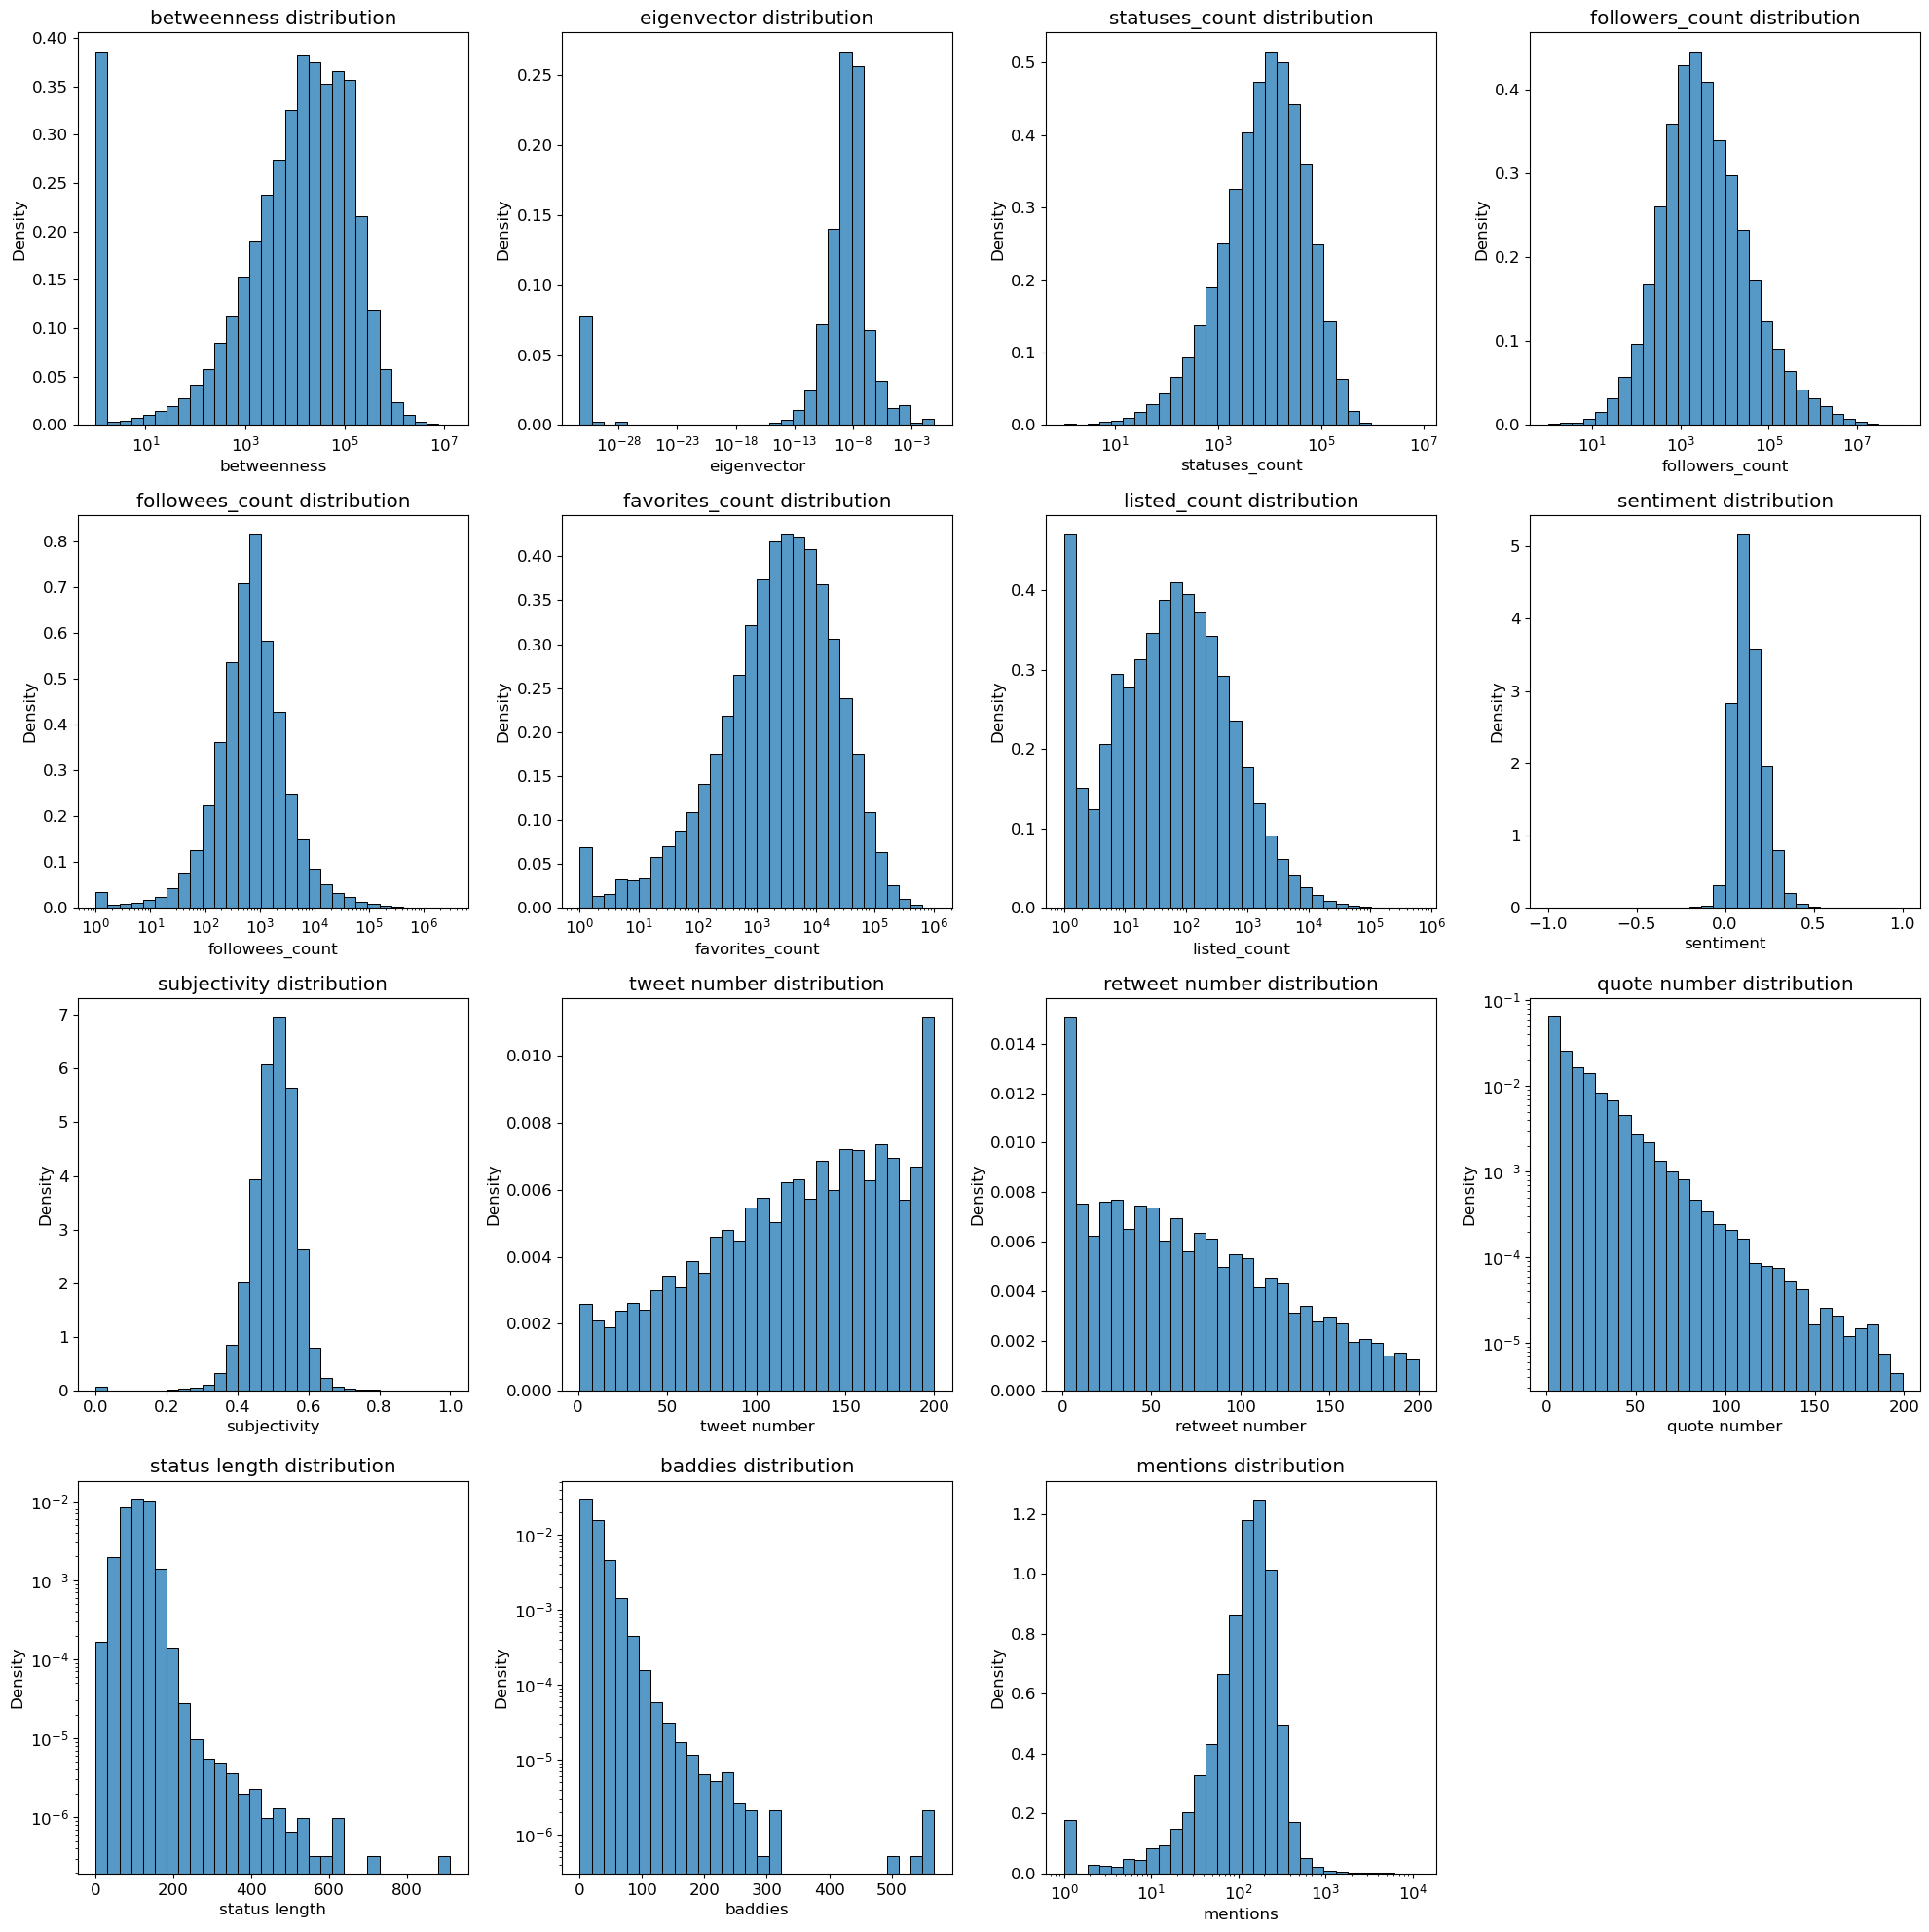

In [141]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i, feature in enumerate(features_analyzed[1:]):
    sns.histplot(df_logscale, x=feature, ax=ax[i // 4, i % 4], log_scale=logscale[i], bins=30, stat="density")
    ax[i // 4, i % 4].set_xlabel(feature)
    ax[i // 4, i % 4].set_ylabel("Density")
    ax[i // 4, i % 4].set_title(f"{feature} distribution")
for i in range(3, 4):
    ax[3, i].set_axis_off()

plt.tight_layout()
plt.savefig(FIGURES_DIR + "features-log.pdf")

Let's have a look at the label distribution

In [ ]:
counts = df["hate"].value_counts()
print(counts)

other      95415
normal      4427
hateful      544
Name: hate, dtype: int64


The number of hateful users is very limited as compared to the number of non-hateful users. This is a typical case of imbalanced dataset. We will have to take this into account when training our models.

In [ ]:
print(
    "Hateful users are {}% of the total, normal users are {}% and unknown users are {}%.".format(
        round(counts["hateful"] / df.shape[0] * 100, 2),
        round(counts["normal"] / df.shape[0] * 100, 2),
        round(counts["other"] / df.shape[0] * 100, 2),
    )
)

Hateful users are 0.54% of the total, normal users are 4.41% and unknown users are 95.05%.


### 1.4. Features by label

In [80]:
hue_order = ["normal", "hateful", "other"]
hue_colors = ["green", "red", "grey"]

We now repeat the previous plots conditional on the label, to see if there are any differences in the distribution of features between hateful and non-hateful users.

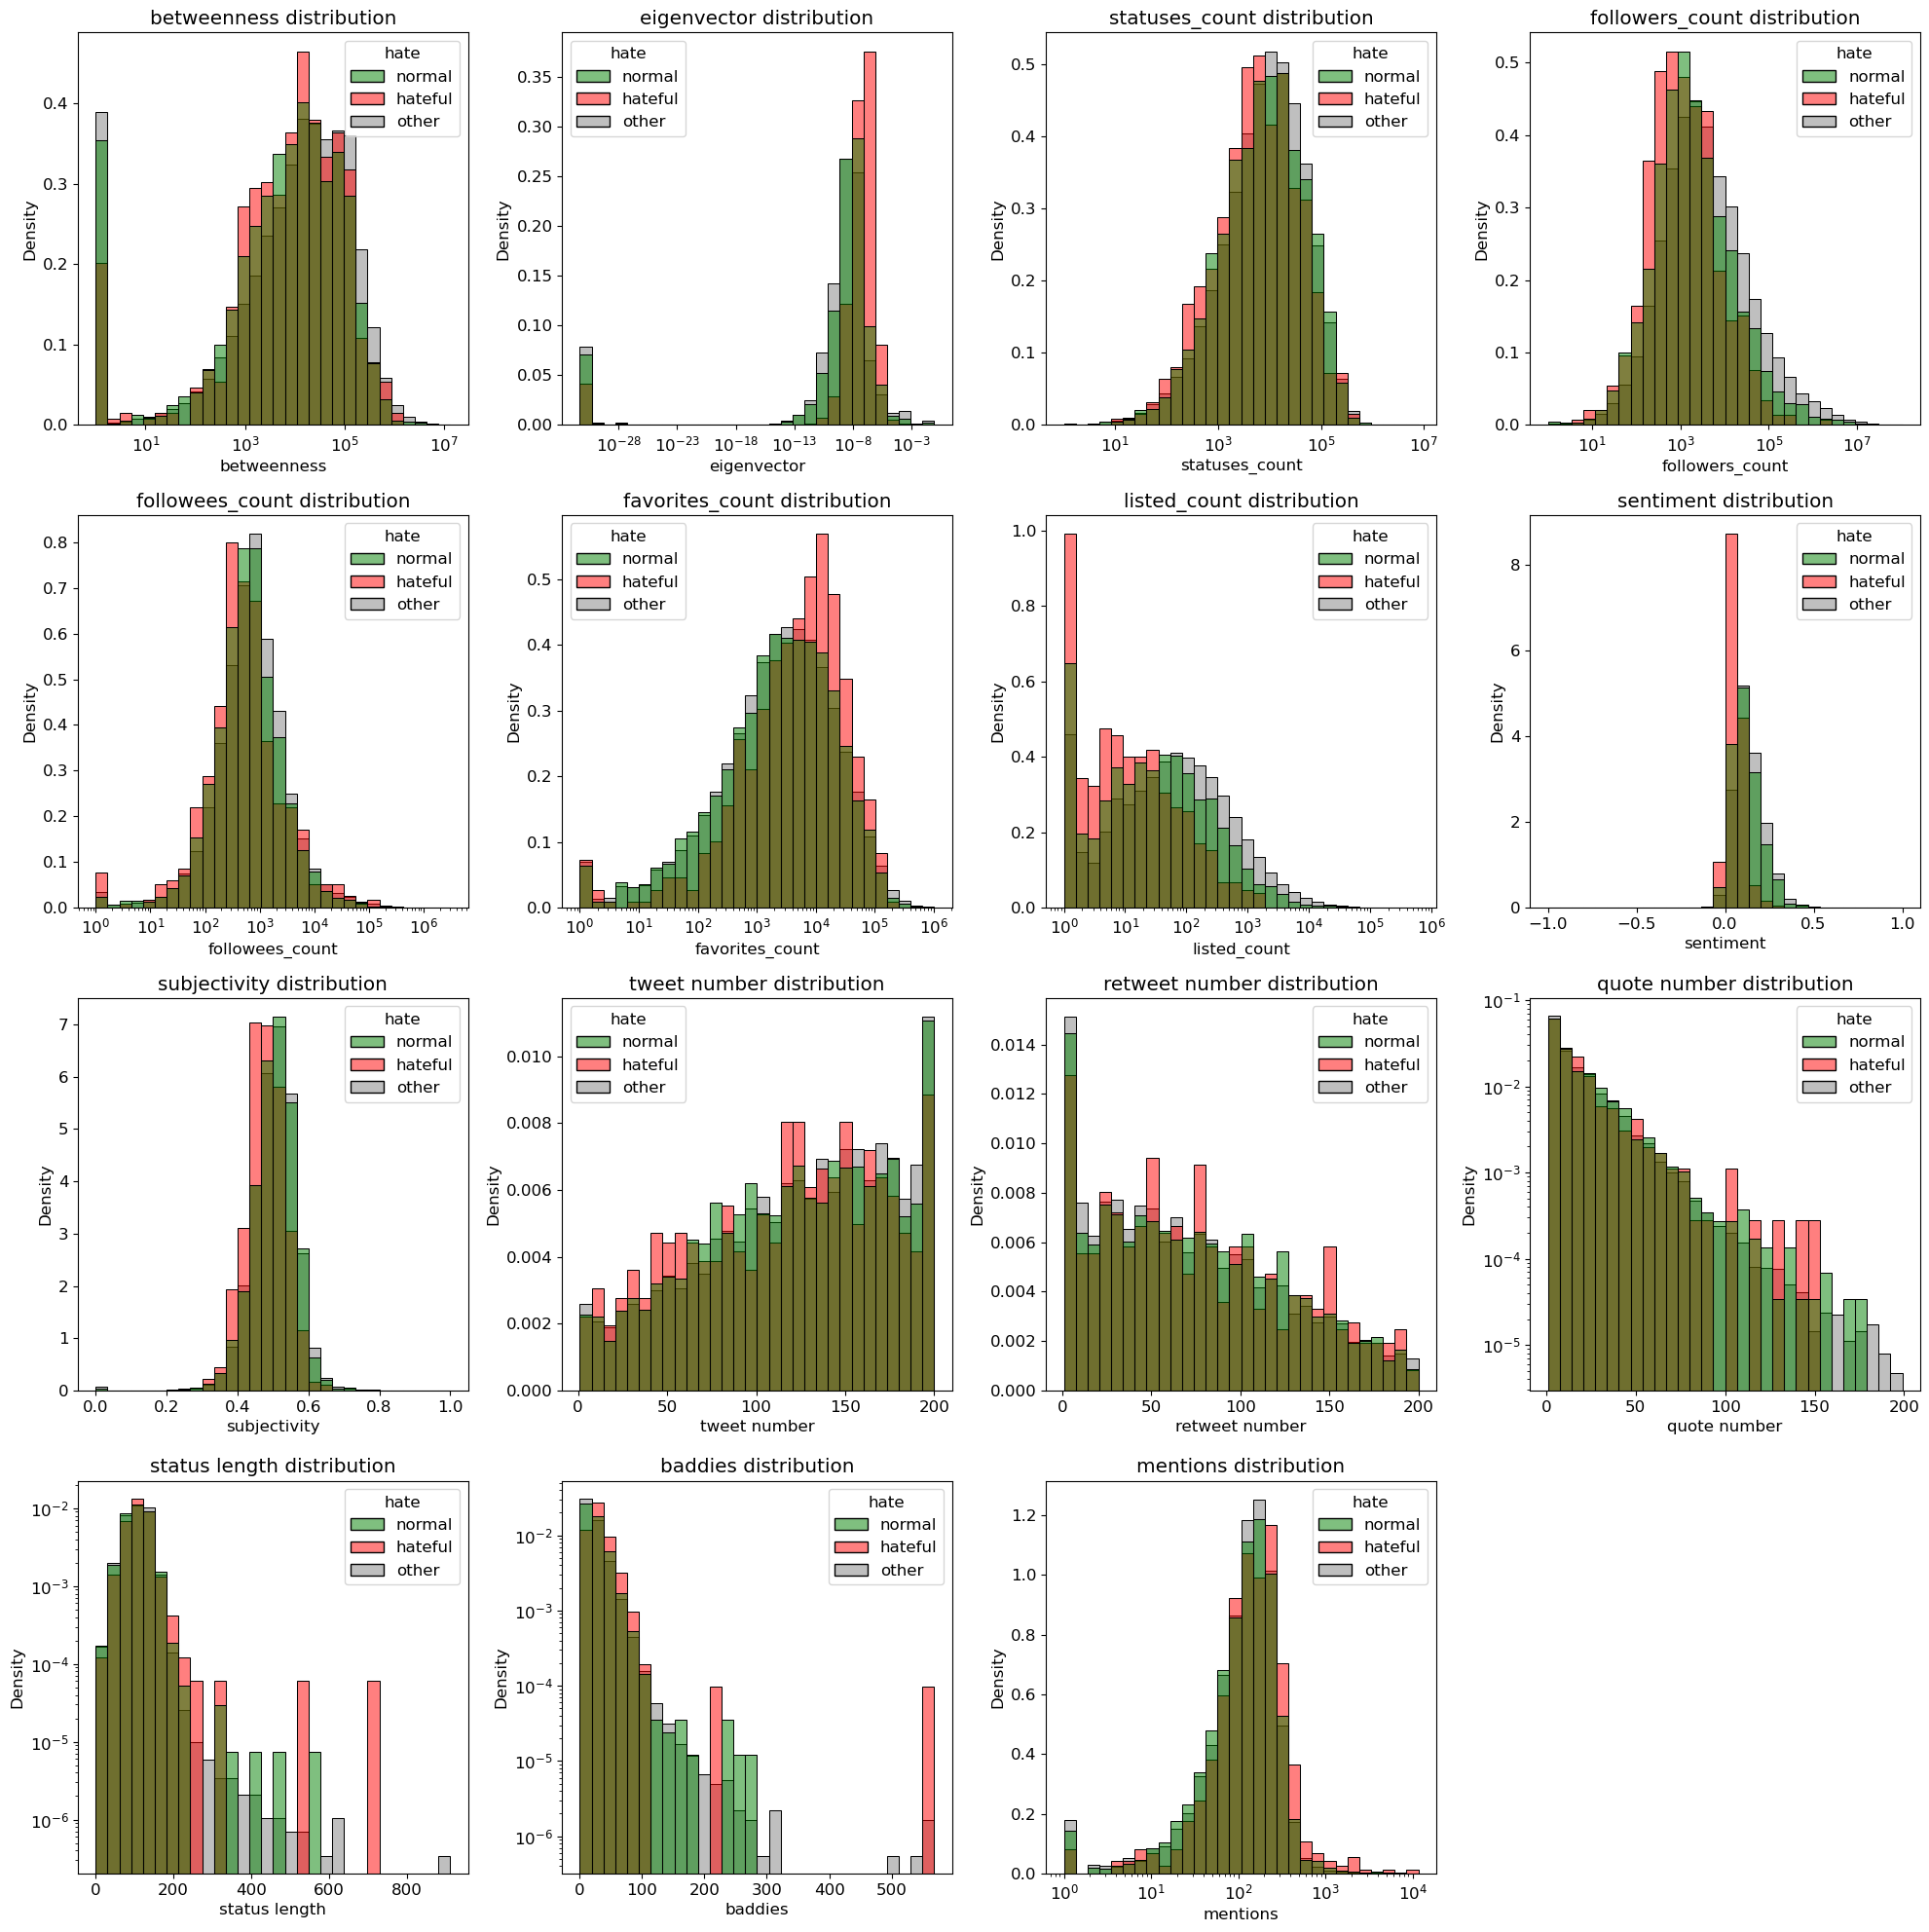

In [139]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))
for i, feature in enumerate(features_analyzed[1:]):
    sns.histplot(df_logscale, x=feature, ax=ax[i // 4, i % 4], log_scale=logscale[i], bins=30, stat="density", hue="hate", 
                 common_norm=False, hue_order=["normal", "hateful", "other"], palette=hue_colors)
    ax[i // 4, i % 4].set_xlabel(feature)
    ax[i // 4, i % 4].set_ylabel("Density")
    ax[i // 4, i % 4].set_title(f"{feature} distribution")
for i in range(3, 4):
    ax[3, i].set_axis_off()

plt.tight_layout()
plt.savefig(FIGURES_DIR + "features-log-hue.pdf")

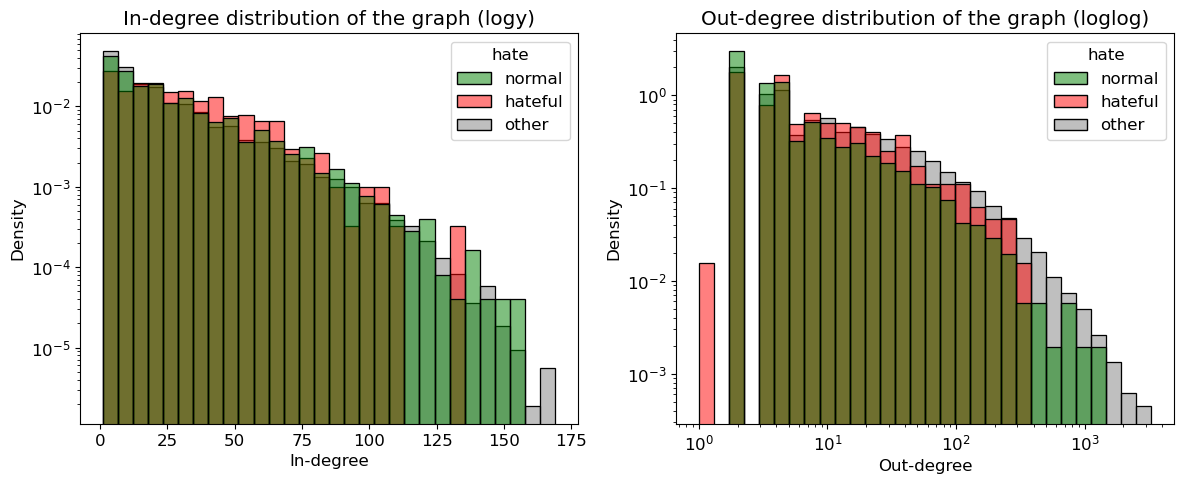

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df, x="in_degree", bins=30, ax=ax[0], log_scale=[False, True], stat="density", hue="hate", 
             common_norm=False, hue_order=["normal", "hateful", "other"], palette=hue_colors)
sns.histplot(df, x="out_degree", bins=30, ax=ax[1], log_scale=[True, True], stat="density", hue="hate", 
             common_norm=False, hue_order=["normal", "hateful", "other"], palette=hue_colors)
ax[0].set_xlabel("In-degree")
ax[1].set_xlabel("Out-degree")
ax[0].set_ylabel("Density")
ax[1].set_ylabel("Density")
ax[0].set_title("In-degree distribution of the graph (logy)")
ax[1].set_title("Out-degree distribution of the graph (loglog)")
plt.tight_layout()
plt.savefig(FIGURES_DIR + "degree-log-hue.pdf")

### 1.5. Subset

Since the retweet graph is very large, we will focus on a subset of it for our analyses. In order to make sure that the chosen sample is representative of the whole graph, we repeat the analyses conducted previously on it and compare the results.

In [ ]:
subset_random = df.sample(5000, random_state=42).user_id.astype(str).values
subset_labeled = df[df.hate.isin(["normal", "hateful"])].user_id.astype(str).values

G_random = G.subgraph(subset_random)
G_labeled = G.subgraph(subset_labeled)

In [ ]:
print(
    f"The random subset contains {G_random.number_of_nodes()} nodes and {G_random.number_of_edges()} edges."
)
print(
    f"The labeled subset contains {G_labeled.number_of_nodes()} nodes and {G_labeled.number_of_edges()} edges."
)

The random subset contains 5000 nodes and 10437 edges.
The labeled subset contains 4971 nodes and 15141 edges.


In [ ]:
in_degrees_random = [G_random.in_degree(n) for n in G_random.nodes()]
out_degrees_random = [G_random.out_degree(n) for n in G_random.nodes()]

in_degrees_labeled = [G_labeled.in_degree(n) for n in G_labeled.nodes()]
out_degrees_labeled = [G_labeled.out_degree(n) for n in G_labeled.nodes()]

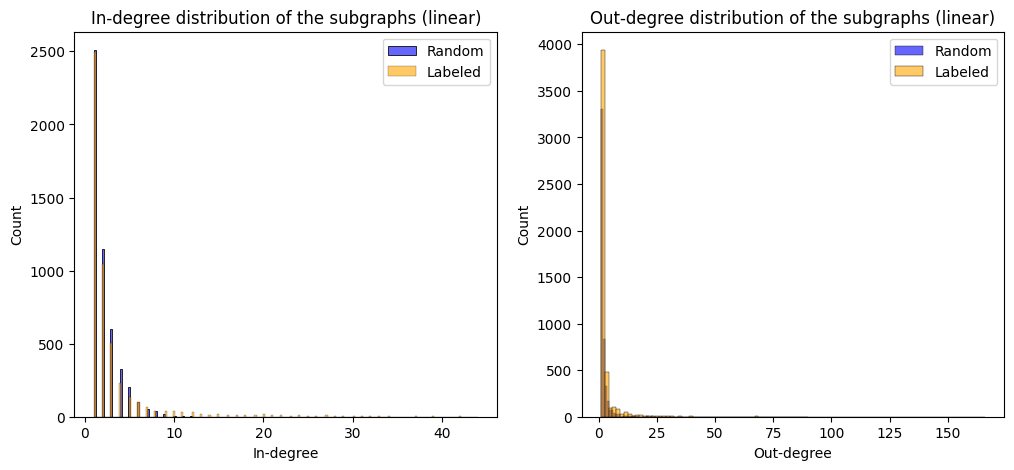

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(in_degrees_random, ax=ax[0], alpha=0.6, color="blue", label="Random")
sns.histplot(in_degrees_labeled, ax=ax[0], alpha=0.6, color="orange", label="Labeled")
sns.histplot(out_degrees_random, bins=100, ax=ax[1], alpha=0.6, color="blue", label="Random")
sns.histplot(out_degrees_labeled, bins=100, ax=ax[1], alpha=0.6, color="orange", label="Labeled")
ax[0].set_xlabel("In-degree")
ax[1].set_xlabel("Out-degree")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Count")
ax[0].legend()
ax[1].legend(["Random", "Labeled"])
ax[0].set_title("In-degree distribution of the subgraphs (linear)")
ax[1].set_title("Out-degree distribution of the subgraphs (linear)")
plt.show()

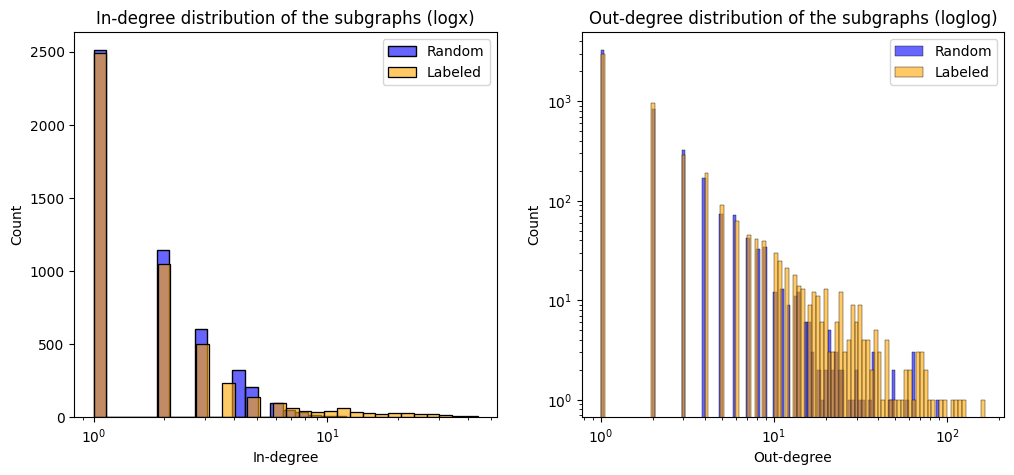

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(in_degrees_random, ax=ax[0], alpha=0.6, color="blue", label="Random", log_scale=[True, False])
sns.histplot(in_degrees_labeled, ax=ax[0], alpha=0.6, color="orange", label="Labeled", log_scale=[True, False])
sns.histplot(out_degrees_random, bins=100, ax=ax[1], alpha=0.6, color="blue", label="Random", log_scale=[True, True])
sns.histplot(out_degrees_labeled, bins=100, ax=ax[1], alpha=0.6, color="orange", label="Labeled", log_scale=[True, True])
ax[0].set_xlabel("In-degree")
ax[1].set_xlabel("Out-degree")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Count")
ax[0].legend()
ax[1].legend(["Random", "Labeled"])
ax[0].set_title("In-degree distribution of the subgraphs (logx)")
ax[1].set_title("Out-degree distribution of the subgraphs (loglog)")
plt.show()

## 2. Network models
We simulate the network using different network models and compare the results with the real network. We use the following network models:
1. Erdos-Renyi
2. Configuration model
3. Scale-free network


In [117]:
average_clustering_coeffient = nx.average_clustering(G)
print(average_clustering_coeffient)

0.05665756186782143


In [ ]:
average_shortest_path_length = nx.average_shortest_path_length(G)
print(average_shortest_path_length)

### 2.1. Erdos-Renyi

In [180]:
n = G.number_of_nodes()
p = G.number_of_edges() / (G.number_of_nodes() * (G.number_of_nodes() - 1))

G_er = nx.fast_gnp_random_graph(n, p, seed=42, directed=True)

In [301]:
p

0.00022690637975636885

In [181]:
print(G_er.number_of_nodes(), G_er.number_of_edges())

100386 2287230


In [304]:
average_clustering_coeffient = nx.average_clustering(G_er)
print(average_clustering_coeffient)

0.00022967454777597724


### 2.2. Configuration model

We fit a configuration model based on the degree distribution of the real network

In [118]:
G_config = nx.directed_configuration_model(in_degrees, out_degrees, create_using=nx.DiGraph)

print(
    "Configuration model has {} nodes and {} edges.".format(
        G_config.number_of_nodes(), G_config.size()
    )
)
print("Original graph has {} nodes and {} edges.".format(G.number_of_nodes(), G.size()))

Configuration model has 100386 nodes and 2281376 edges.
Original graph has 100386 nodes and 2286592 edges.


In [119]:
print("Number of self-loops in original graph: {}".format(nx.number_of_selfloops(G)))

Number of self-loops in original graph: 100386


In [144]:
average_clustering_coeffient = nx.average_clustering(G_config)
print(average_clustering_coeffient)

0.0021337294902195668


### 2.3. Scale-free network

In [297]:
G_sf = nx.scale_free_graph(n, alpha=0.01, beta=0.95, gamma=0.04, seed=42, delta_in=0, delta_out=0.4, initial_graph=nx.DiGraph)

In [298]:
G_sf.number_of_nodes(), G_sf.number_of_edges()

(100386, 2006400)

In [296]:
G_sf_dir = nx.DiGraph(G_sf)

G_sf_dir.number_of_nodes(), G_sf_dir.number_of_edges()

(100386, 333062)

In [300]:
average_clustering_coeffient = nx.average_clustering(G_sf_dir)
print(average_clustering_coeffient)

0.25308757749297356


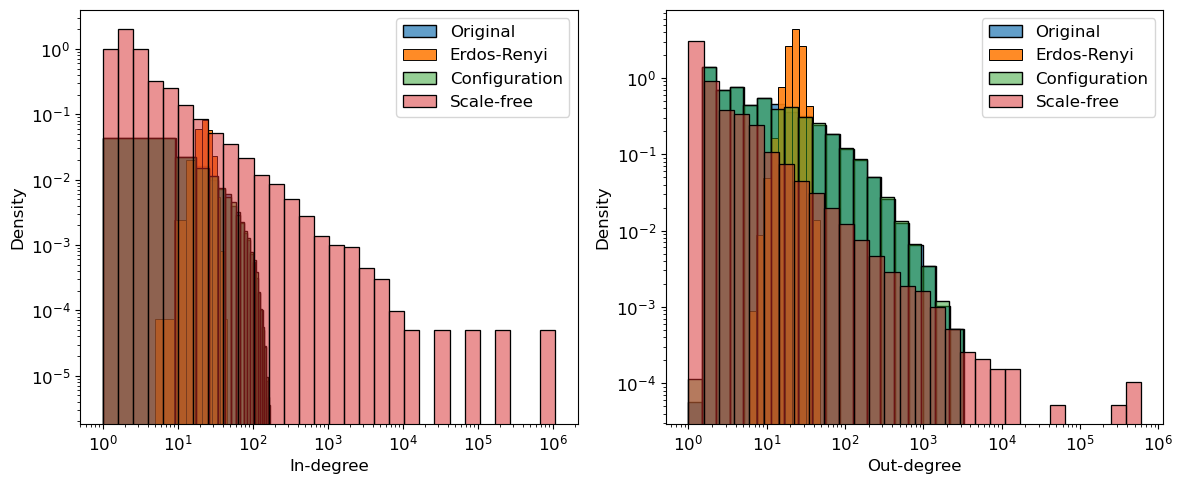

In [286]:
# Plot the degree distribution of the erdos-renyi model, the configuration model and the original graph
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]
in_degrees_er = [G_er.in_degree(n) for n in G_er.nodes()]
out_degrees_er = [G_er.out_degree(n) for n in G_er.nodes()]
in_degrees_config = [G_config.in_degree(n) for n in G_config.nodes()]
out_degrees_config = [G_config.out_degree(n) for n in G_config.nodes()]
in_degree_sf = [G_sf.in_degree(n) for n in G_sf.nodes()]
out_degree_sf = [G_sf.out_degree(n) for n in G_sf.nodes()]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(in_degrees, bins=20, ax=ax[0], alpha=0.7, label="Original", stat="density", log_scale=[False, True])
sns.histplot(in_degrees_er, bins=10, ax=ax[0], alpha=0.9, label="Erdos-Renyi", stat="density", log_scale=[False, True])
sns.histplot(in_degrees_config, bins=20, ax=ax[0], alpha=0.5, label="Configuration", stat="density", log_scale=[False, True])
sns.histplot(np.array(in_degree_sf)+1, bins=30, ax=ax[0], alpha=0.5, label="Scale-free", stat="density", log_scale=[True, True])

sns.histplot(out_degrees, bins=20, ax=ax[1], alpha=0.7, label="Original", stat="density", log_scale=[True, True])
sns.histplot(out_degrees_er, bins=10, ax=ax[1], alpha=0.9, label="Erdos-Renyi", stat="density", log_scale=[True, True])
sns.histplot(out_degrees_config, bins=20, ax=ax[1], alpha=0.5, label="Configuration", stat="density", log_scale=[True, True])
sns.histplot(np.array(out_degree_sf)+1, bins=30, ax=ax[1], alpha=0.5, label="Scale-free", stat="density", log_scale=[True, True])

ax[0].legend()
ax[1].legend()

ax[0].set_xlabel("In-degree")
ax[1].set_xlabel("Out-degree")
ax[0].set_ylabel("Density")

plt.tight_layout()
plt.savefig(FIGURES_DIR + "random_models.pdf")

## 3. Graphlets

We run the script ```collect_graphlets.py``` to compute the triadic census of the graph. We then plot the distribution of graphlets in the real graph and in the simulated ones.

In [336]:
triadic_types = defaultdict(lambda: nx.DiGraph())

triadic_types["003"].add_nodes_from([1, 2, 3])
triadic_types["012"].add_nodes_from([1, 2, 3])
triadic_types["012"].add_edges_from([(1, 2)])
triadic_types["021C"].add_edges_from([(1, 2), (2, 3)])
triadic_types["021D"].add_edges_from([(2, 1), (2, 3)])
triadic_types["021U"].add_edges_from([(1, 2), (3, 2)])
triadic_types["030C"].add_edges_from([(1, 3), (3, 2), (2, 1)])
triadic_types["030T"].add_edges_from([(1, 3), (3, 2), (1, 2)])
triadic_types["102"].add_nodes_from([1, 2, 3])
triadic_types["102"].add_edges_from([(1, 2), (2, 1)])
triadic_types["111D"].add_edges_from([(1, 3), (3, 1), (2, 3)])
triadic_types["111U"].add_edges_from([(1, 3), (3, 1), (3, 2)])
triadic_types["120C"].add_edges_from([(1, 3), (3, 1), (1, 2), (2, 3)])
triadic_types["120D"].add_edges_from([(1, 3), (3, 1), (2, 1), (2, 3)])
triadic_types["120U"].add_edges_from([(1, 3), (3, 1), (1, 2), (3, 2)])
triadic_types["201"].add_edges_from([(1, 2), (2, 1), (1, 3), (3, 1)])
triadic_types["210"].add_edges_from([(1, 2), (1, 3), (3, 1), (2, 3), (3, 2)])
triadic_types["300"].add_edges_from([(1, 2), (1, 3), (3, 1), (2, 3), (3, 2), (2, 1)])

In [337]:
layout = {1: np.array([-1, -1/3]),
          3: np.array([ 1, -1/3]),
          2: np.array([0, 2/3])}

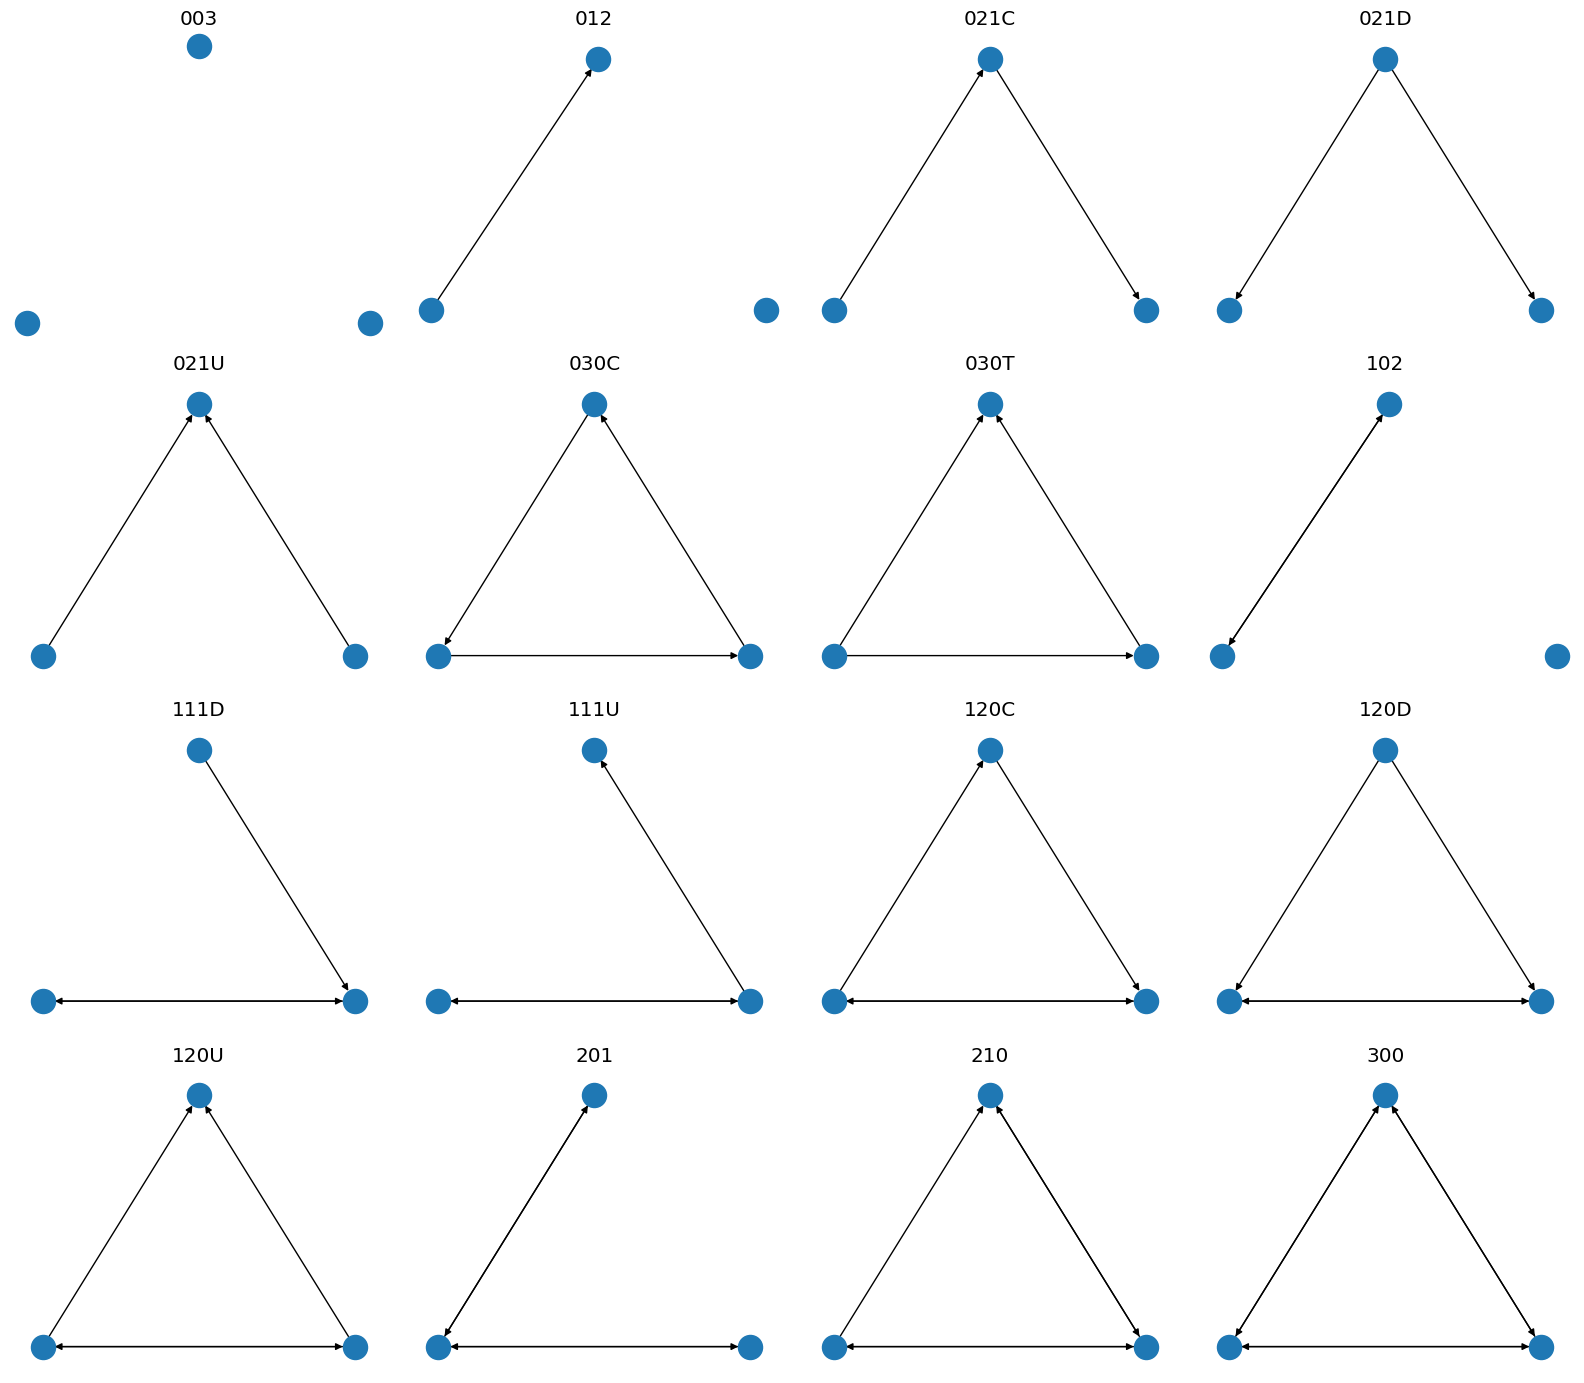

In [339]:
fig, ax = plt.subplots(4, 4, figsize=(16, 14))
plt.rcParams["figure.facecolor"] = "white"
for i, axs in enumerate(ax.flatten()):
    nx.draw_networkx(list(triadic_types.values())[i], pos=layout, ax=axs, with_labels=False)
    axs.axis("off")
    axs.set_title(list(triadic_types.keys())[i])

plt.tight_layout()
plt.savefig(FIGURES_DIR + "triadic_types.pdf")

In [ ]:
Z_score = pd.read_csv(BASE_DIR + "triadic_census_zscores.csv", index_col=0)

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=Z_score.index, y=Z_score.values, marker="o")
sns.lineplot(x=Z_score.index, y=[0]*len(Z_score.index))
plt.xlabel("Type of triad")
plt.ylabel("Z-score")
plt.savefig("z-scores.pdf")
plt.show()